# HAM10000 ConvNet

Convolutional neural network for identifying skin lesions, using the [HAM10000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). 

I trained the ConvNet using [Google Colaboratory](https://colab.research.google.com/). 

## Setup

Import/install required libraries.

In [1]:
%tensorflow_version 2.x
%matplotlib inline 

import datetime
import io
import json
import math
import numpy as np
import os
import pandas as pd
import seaborn as sn
import tensorflow as tf

from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.models import Sequential, Input, Model
from timeit import default_timer as timer

# other important info
batch_size = 64
epochs = 30
dx_ints = {"akiec": 0, "bcc": 1, "bkl": 2,
           "df": 3, "nv": 4, "vasc": 5, "mel": 6}
dx_list = ["akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"]
num_classes = len(dx_list)
base_dir = "/content/drive/My Drive/Colab Notebooks/HAM_ConvNet"

print("Tensorflow version used:", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version used: 2.2.0


Mounts Google Drive, where I stored the input data sets. 

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Function to pre-process data, splits them into train, validation, and test subsets. 

In [0]:
def preprocess_data(file_name):
    # read data
    dataset = pd.read_csv(os.path.join(base_dir, file_name), header=0)

    # infer image resolution (assumes square images!)
    img_dim = int(math.sqrt(len(dataset.columns)))

    # split data to images and labels
    data_x = np.array([np.reshape(row.to_numpy(), (-1, img_dim)) for _,
                                                                     row in dataset.iloc[:, :-1].iterrows()])
    data_y = dataset.loc[:, "label"].to_numpy()

    # split to training and testing subsets
    train_X, test_X, train_Y, test_Y = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=624)

    # reshape data to 2D arrays
    train_X = train_X.reshape(-1, img_dim, img_dim, 1)
    test_X = test_X.reshape(-1, img_dim, img_dim, 1)

    # convert grayscale values to 0-1 scale
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    # change the labels from categorical to one-hot encoding
    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    # split train data again to create validation subset
    train_X, valid_X, train_label, valid_label = train_test_split(
        train_X, train_Y_one_hot, test_size=0.2, random_state=624)

    # package results in dictionary
    res = {"trX": train_X, "valX": valid_X,
           "trLab": train_label, "valLab": valid_label,
           "tesX": test_X, "tesYhot": test_Y_one_hot, "tesY": test_Y,
           "img_dim": img_dim}

    return res

Function to create and compile the ConvNet model.

In [0]:
def create_conv_net_model(img_dim):
    # set up convNet model
    # configuration of the model from this tutorial:
    # https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
    ham_model = Sequential()
    ham_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear',
                         padding='same', input_shape=(img_dim, img_dim, 1)))
    ham_model.add(LeakyReLU(alpha=0.1))
    ham_model.add(MaxPooling2D((2, 2), padding='same'))
    ham_model.add(Dropout(0.25))
    ham_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
    ham_model.add(LeakyReLU(alpha=0.1))
    ham_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    ham_model.add(Dropout(0.25))
    ham_model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
    ham_model.add(LeakyReLU(alpha=0.1))
    ham_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    ham_model.add(Dropout(0.4))
    ham_model.add(Flatten())
    ham_model.add(Dense(128, activation='linear'))
    ham_model.add(LeakyReLU(alpha=0.1))
    ham_model.add(Dropout(0.3))
    ham_model.add(Dense(num_classes, activation='softmax'))

    # compile model
    ham_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    return ham_model

Function that trains and evaluates the network. 

In [0]:
def train_conv_net(data_file_name, batch_size=batch_size, epochs=epochs,
                   verbose=1):
    # set timer to measure process time
    start = timer()

    # get data
    data = preprocess_data(data_file_name)

    # create model
    model = create_conv_net_model(data["img_dim"])

    # train model
    model_train_info = model.fit(data["trX"], data["trLab"], batch_size, epochs,
                                 verbose, validation_data=(data["valX"],
                                                           data["valLab"]))

    # save trained model
    model_dir_name = f"{data_file_name.strip('.csv')}_model"
    model.save(os.path.join(base_dir, "HAM_models", model_dir_name))

    # evaluate
    test_eval = model.evaluate(data["tesX"], data["tesYhot"])
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    # get training info
    accuracy = model_train_info.history['accuracy']
    val_accuracy = model_train_info.history['val_accuracy']
    loss = model_train_info.history['loss']
    val_loss = model_train_info.history['val_loss']

    # make predictions
    predicted_classes = model.predict(data["tesX"])
    predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

    # create classification report
    target_names = dx_list  # [f"Class {dx}" for dx in dx_list]
    report = classification_report(data["tesY"], predicted_classes,
                                   target_names=target_names, output_dict=True)
    report = pd.DataFrame(report)

    # create confusion matrix
    cm = confusion_matrix(data["tesY"], predicted_classes)
    df_cm = pd.DataFrame(cm, dx_list, dx_list)

    end = timer()

    # package results 
    res = {"test_eval": test_eval, "accuracy": accuracy,
           "val_accuracy": val_accuracy, "loss": loss, "val_loss": val_loss,
           "predicted_classes": predicted_classes, "test_Y": data["tesY"],
           "confusion_matrix": df_cm, "report": report, "model": model,
           "run_time": end - start}

    return res

## Training networks

I trained the 5 ConvNets, using 5 different data sets:

1.   Data set with 8x8 pixel images (as provided in the HAM data set).
2.   Data set with 28x28 images (as provided in the HAM data set).
3.   Data set with 28x28 images, same as above, but with augmented lesion types to 2000 images per category. 
4.   Data set with 42x42 images, that I created, with augmented lesion types to 2000 per category. 
5.   Data set with 64x64 images, that I created, with augmented lesion types to 2000 per category.

The networks were all trained for 30 epochs. The cells below show information about the training of these networks, as well as their evaluation.

In [7]:
net8 = train_conv_net("hmnist_8_8_L.csv")

Epoch 1/30
101/101 [==============================] - 2s 16ms/step - loss: 1.2248 - accuracy: 0.6553 - val_loss: 1.0951 - val_accuracy: 0.6862
Epoch 2/30
101/101 [==============================] - 1s 14ms/step - loss: 1.1487 - accuracy: 0.6634 - val_loss: 1.0879 - val_accuracy: 0.6862
Epoch 3/30
101/101 [==============================] - 1s 15ms/step - loss: 1.1170 - accuracy: 0.6634 - val_loss: 1.0798 - val_accuracy: 0.6862
Epoch 4/30
101/101 [==============================] - 1s 15ms/step - loss: 1.0828 - accuracy: 0.6633 - val_loss: 1.0338 - val_accuracy: 0.6862
Epoch 5/30
101/101 [==============================] - 1s 15ms/step - loss: 1.0597 - accuracy: 0.6631 - val_loss: 0.9933 - val_accuracy: 0.6875
Epoch 6/30
101/101 [==============================] - 1s 15ms/step - loss: 1.0454 - accuracy: 0.6636 - val_loss: 0.9757 - val_accuracy: 0.6862
Epoch 7/30
101/101 [==============================] - 1s 15ms/step - loss: 1.0237 - accuracy: 0.6642 - val_loss: 0.9692 - val_accuracy: 0.6893

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
net28 = train_conv_net("hmnist_28_28_L.csv")

Epoch 1/30
101/101 [==============================] - 12s 118ms/step - loss: 1.1883 - accuracy: 0.6597 - val_loss: 1.1725 - val_accuracy: 0.6862
Epoch 2/30
101/101 [==============================] - 12s 116ms/step - loss: 1.1346 - accuracy: 0.6634 - val_loss: 1.1458 - val_accuracy: 0.6862
Epoch 3/30
101/101 [==============================] - 12s 116ms/step - loss: 1.0739 - accuracy: 0.6620 - val_loss: 0.9952 - val_accuracy: 0.6856
Epoch 4/30
101/101 [==============================] - 12s 116ms/step - loss: 1.0249 - accuracy: 0.6623 - val_loss: 0.9635 - val_accuracy: 0.6818
Epoch 5/30
101/101 [==============================] - 12s 116ms/step - loss: 0.9817 - accuracy: 0.6691 - val_loss: 0.9029 - val_accuracy: 0.6956
Epoch 6/30
101/101 [==============================] - 12s 117ms/step - loss: 0.9503 - accuracy: 0.6786 - val_loss: 0.8980 - val_accuracy: 0.7031
Epoch 7/30
101/101 [==============================] - 12s 117ms/step - loss: 0.9113 - accuracy: 0.6876 - val_loss: 0.8667 - val_ac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
net28_aug = train_conv_net("hmnist_28_28_2000.csv")

Epoch 1/30
188/188 [==============================] - 22s 118ms/step - loss: 1.7317 - accuracy: 0.3656 - val_loss: 1.5461 - val_accuracy: 0.4173
Epoch 2/30
188/188 [==============================] - 22s 117ms/step - loss: 1.5505 - accuracy: 0.4127 - val_loss: 1.4608 - val_accuracy: 0.4584
Epoch 3/30
188/188 [==============================] - 22s 118ms/step - loss: 1.4516 - accuracy: 0.4477 - val_loss: 1.3091 - val_accuracy: 0.5112
Epoch 4/30
188/188 [==============================] - 22s 118ms/step - loss: 1.3881 - accuracy: 0.4731 - val_loss: 1.3186 - val_accuracy: 0.5229
Epoch 5/30
188/188 [==============================] - 22s 118ms/step - loss: 1.3231 - accuracy: 0.4989 - val_loss: 1.3400 - val_accuracy: 0.5095
Epoch 6/30
188/188 [==============================] - 22s 117ms/step - loss: 1.2830 - accuracy: 0.5187 - val_loss: 1.1926 - val_accuracy: 0.5556
Epoch 7/30
188/188 [==============================] - 22s 117ms/step - loss: 1.2465 - accuracy: 0.5258 - val_loss: 1.4083 - val_ac

In [10]:
net42_aug = train_conv_net("hmnist_42_42_2000.csv")

Epoch 1/30
188/188 [==============================] - 51s 271ms/step - loss: 1.7465 - accuracy: 0.3599 - val_loss: 1.5698 - val_accuracy: 0.4130
Epoch 2/30
188/188 [==============================] - 51s 269ms/step - loss: 1.5447 - accuracy: 0.4117 - val_loss: 1.4476 - val_accuracy: 0.4674
Epoch 3/30
188/188 [==============================] - 50s 268ms/step - loss: 1.4348 - accuracy: 0.4615 - val_loss: 1.3752 - val_accuracy: 0.4567
Epoch 4/30
188/188 [==============================] - 51s 269ms/step - loss: 1.3498 - accuracy: 0.4969 - val_loss: 1.2478 - val_accuracy: 0.5326
Epoch 5/30
188/188 [==============================] - 51s 269ms/step - loss: 1.2857 - accuracy: 0.5217 - val_loss: 1.3585 - val_accuracy: 0.4992
Epoch 6/30
188/188 [==============================] - 51s 270ms/step - loss: 1.2475 - accuracy: 0.5312 - val_loss: 1.1435 - val_accuracy: 0.5673
Epoch 7/30
188/188 [==============================] - 51s 270ms/step - loss: 1.1951 - accuracy: 0.5540 - val_loss: 1.1137 - val_ac

In [11]:
net64_aug = train_conv_net("hmnist_64_64_2000.csv")

Epoch 1/30
188/188 [==============================] - 106s 566ms/step - loss: 1.7327 - accuracy: 0.3598 - val_loss: 1.5768 - val_accuracy: 0.4150
Epoch 2/30
188/188 [==============================] - 109s 579ms/step - loss: 1.5000 - accuracy: 0.4335 - val_loss: 1.4162 - val_accuracy: 0.4758
Epoch 3/30
188/188 [==============================] - 106s 566ms/step - loss: 1.3856 - accuracy: 0.4784 - val_loss: 1.3127 - val_accuracy: 0.5075
Epoch 4/30
188/188 [==============================] - 107s 567ms/step - loss: 1.2930 - accuracy: 0.5167 - val_loss: 1.2813 - val_accuracy: 0.5282
Epoch 5/30
188/188 [==============================] - 106s 566ms/step - loss: 1.2385 - accuracy: 0.5391 - val_loss: 1.2666 - val_accuracy: 0.5469
Epoch 6/30
188/188 [==============================] - 106s 565ms/step - loss: 1.1853 - accuracy: 0.5576 - val_loss: 1.1279 - val_accuracy: 0.5927
Epoch 7/30
188/188 [==============================] - 106s 564ms/step - loss: 1.1369 - accuracy: 0.5781 - val_loss: 1.1310 -

## Results

The results from the training of networks are presented in this section. 

Below I present the results in a series of graphs.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


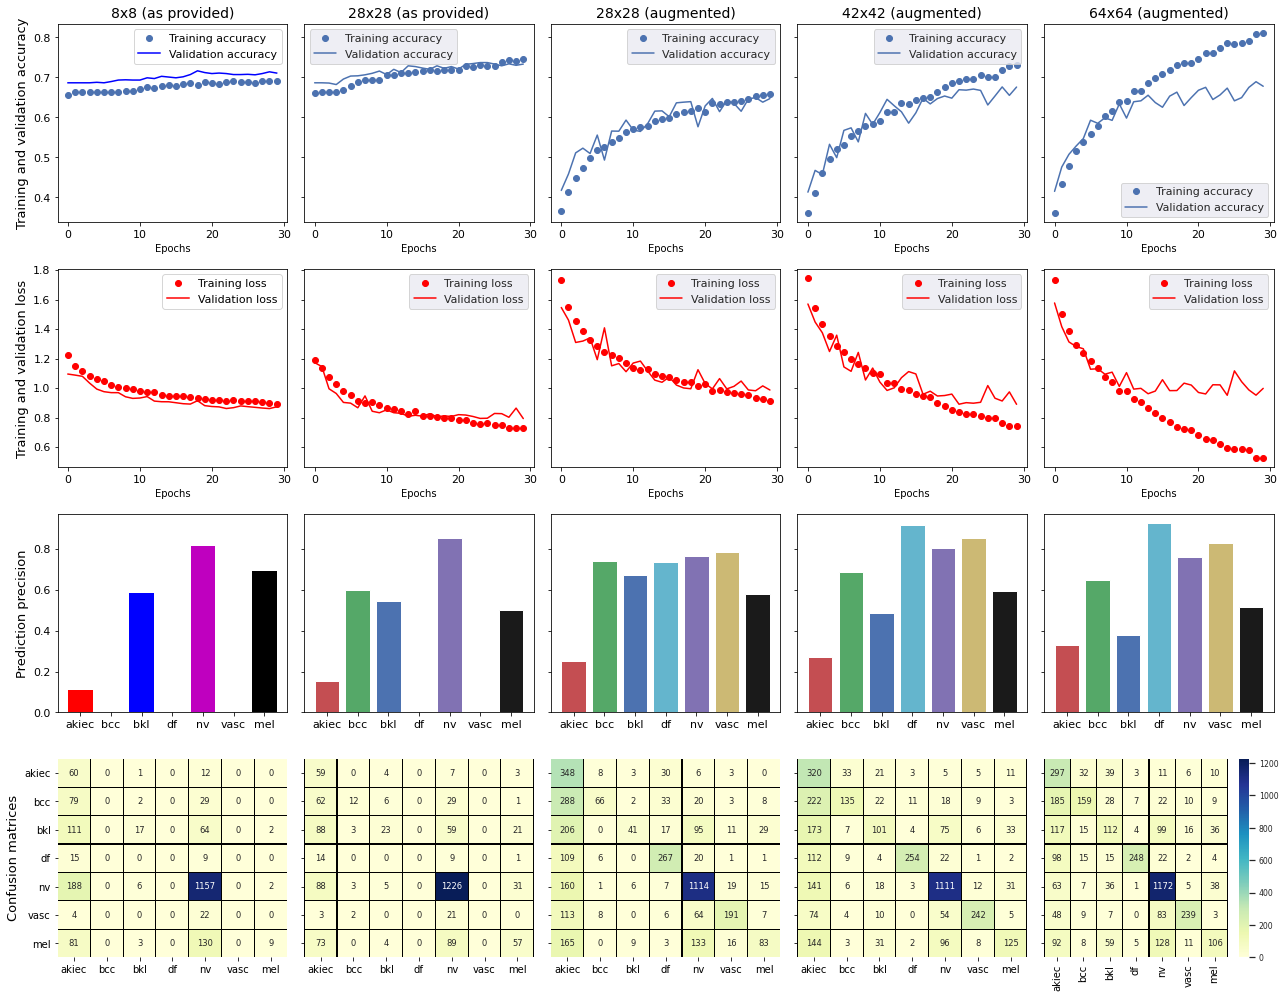

In [12]:
all_data = [net8, net28, net28_aug, net42_aug, net64_aug]

titles = ["8x8 (as provided)", "28x28 (as provided)", "28x28 (augmented)", 
          "42x42 (augmented)", "64x64 (augmented)"]

# Find colorbar max for confusion matrices
cbar_max = max(max(d["confusion_matrix"].max(axis=1)) for d in all_data)

# create figure
fig, axes = plt.subplots(4, 5, sharey="row", figsize=(18,14),
                         num="default", squeeze=True)
epch = range(epochs)

# add graphs to figure
for i, r in enumerate(all_data):

  axes[0, i].set_title(titles[i], fontsize=14)

  # Training and validation accuracy graphs
  if i == 0: axes[0, i].set_ylabel("Training and validation accuracy",
                                   fontsize=13)
  axes[0, i].set_xlabel("Epochs", fontsize=10)
  axes[0, i].plot(epch, r["accuracy"], "bo", label='Training accuracy')
  axes[0, i].plot(epch, r["val_accuracy"], "b", label='Validation accuracy')
  axes[0, i].legend(fontsize=11)
  axes[0, i].tick_params(axis='both', which='major', labelsize=11)

  # Training and validation loss graphs
  if i == 0: axes[1, i].set_ylabel("Training and validation loss", fontsize=13)
  axes[1, i].set_xlabel("Epochs", fontsize=10)
  axes[1, i].plot(epch, r["loss"], "bo",  label='Training loss', color ="red")  
  axes[1, i].plot(epch, r["val_loss"], "b", label='Validation loss',
                  color ="red")
  axes[1, i].legend(fontsize=11)
  axes[1, i].tick_params(axis='both', which='major', labelsize=11)

  # Prediction precision graphs
  df = r["report"].T
  bar_data = df.loc["akiec":"mel","precision"]
  if i == 0: axes[2, i].set_ylabel("Prediction precision", fontsize=13)
  axes[2, i].bar(bar_data.index, bar_data, color="rgbcmyk")
  axes[2, i].tick_params(axis='both', which='major', labelsize=11)

  # Confusion matrices  
  cm = confusion_matrix(r["test_Y"], r["predicted_classes"])
  df_cm = pd.DataFrame(cm, dx_list, dx_list)
  sn.set(font_scale=.7)
  sn.heatmap(df_cm, ax=axes[3, i], vmin=0, vmax=cbar_max, annot=True, 
             cmap="YlGnBu", cbar=i==len(all_data)-1, fmt="d", 
             linewidths=0.1, linecolor="black")
  if i == 0: axes[3, i].set_ylabel("Confusion matrices", fontsize=13)

fig.tight_layout()
fig.savefig("figure_convNetRes.svg", bbox_inches="tight")
fig.savefig("figure_convNetRes.pdf", bbox_inches="tight")
fig.show()

In [17]:
# create results table
evaluation_data = pd.DataFrame([d["test_eval"] for d in all_data], index=titles,
                               columns=["Test loss", "Test accuracy"])
times = [67, 508, 1313, 3163, 5906]
evaluation_data["Training time"] = [str(datetime.timedelta(seconds=round(d["run_time"]))) for d in all_data]
evaluation_data["Epochs"] = [epochs]*5

# re-arrange columns 
evaluation_data = evaluation_data.iloc[:,[3,2,0,1]]
# save to file
evaluation_data.to_csv("table_results.csv")

evaluation_data

,Epochs,Training time,Test loss,Test accuracy
8x8 (as provided),30,0:00:49,0.866820,0.710934
28x28 (as provided),30,0:06:07,0.785197,0.729905
28x28 (augmented),30,0:11:25,0.999897,0.620690
42x42 (augmented),30,0:25:51,0.944596,0.659984
64x64 (augmented),30,0:54:19,1.101086,0.652767


In [18]:
# Convert models
converter = tf.lite.TFLiteConverter.from_keras_model(net28_aug["model"])
tflite_model = converter.convert()
# tflite_model.save(f"{base_dir}/HAM_models/tflite_28")
print(type(tflite_model))
print(len(tflite_model))
with open(f"{base_dir}/HAM_models/tflite_28", "wb") as f:
  f.write(tflite_model)

<class 'bytes'>
1426824
